In [1]:
from cogpred.utils.naming import make_run_path
import joblib
from cogpred.utils.configuration import get_config
from pathlib import Path

config = get_config()
dir = Path(config["output_dir"]) / "prediction"
ATLAS = "schaefer200"
k = 3

conn_dir = config["connectivity_matrices"]

In [2]:
import joblib
# TODO make eval dict to sort experiments
scores = []
names = []
for subdir in dir.iterdir():
    try:
        res = joblib.load(subdir / "test_scores.joblib")
    except FileNotFoundError:
        print(f"{subdir.name} has no available score")
        continue
    if "experimental-True" not in subdir.name:
        scores.append(res)
        names.append(subdir.name)

k-3_feat-series_experimental-True_atlas-schaefer200 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-04 18:10:38 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 10:30:43 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 11:16:56 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 12:13:19 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:00:50 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:02:36 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:06:46 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:49:20 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024

## Display outer cv results

In [3]:
import pandas as pd
import seaborn as sns
def shorten(long_name):
    return long_name.split("_")[1].split("-")[1]

df = pd.DataFrame(scores, index=[name[9:] for name in names], columns=[f"split_{i+1}" for i in range(len(res))])
df

,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8
fc_atlas-schaefer200_groupkfold-True_net-allbrain,0.361941,0.375460,0.350978,0.325789,0.305397,0.298814,0.336853,0.325345
volumetry_atlas-schaefer200_experimental-False,0.486414,0.444630,0.382470,0.388240,0.441742,0.421520,0.330525,0.397381
dummy_experimental-False,0.274510,0.275910,0.287053,0.305210,0.281736,0.257937,0.275177,0.288799
fc_atlas-schaefer200_groupkfold-True_net-Default,0.352638,0.368678,0.343780,0.323266,0.311541,0.376377,0.390324,0.316162


In [4]:
df.mean(axis=1)

fc_atlas-schaefer200_groupkfold-True_net-allbrain    0.335072
volumetry_atlas-schaefer200_experimental-False       0.411615
dummy_experimental-False                             0.280792
fc_atlas-schaefer200_groupkfold-True_net-Default     0.347846
dtype: float64

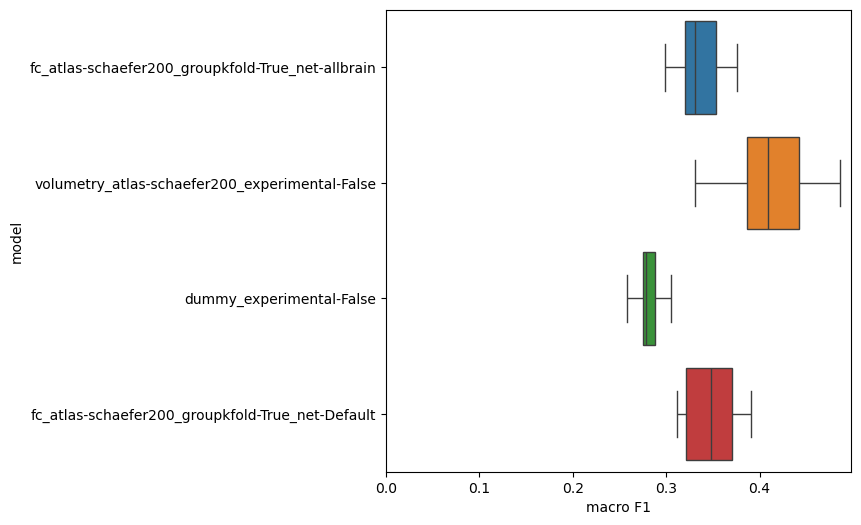

In [5]:
import matplotlib.pyplot as plt
m = df.T.melt(var_name="model", value_name="macro F1")
plt.subplots(figsize=(6, 6))
sns.boxplot(m, x="macro F1", y="model", hue="model")
plt.xlim(0)
plt.show()

## NN inference on test set

In [6]:
import numpy as np
from cogpred.features import make_features
from cogpred.loading import make_test_data, TSFetcher
from neuroginius.atlas import Atlas
ATLAS = "schaefer200"
tspath = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")


In [7]:
atlas = Atlas.from_name(ATLAS)
matrices, metadata = make_test_data(conn_dir, ATLAS, k=3)
dmn_indexer = np.where(np.array(atlas.macro_labels) == "Default", True, False)
fetcher = TSFetcher(tspath)
features = make_features(fetcher, metadata, dmn_indexer)

Dropping 4 subjects because of lacking MMMSE


In [8]:
y_true = metadata.cluster_label.values.astype(int)

In [16]:
from collections import OrderedDict
from cogpred.models import default_channel_func, initial_bump, slow_increase, fast_increase, constant_channels

EXPDIR = "/homes_unix/jlegrand/data/Memento/output/prediction"
exppath = Path(EXPDIR) / "k-3_feat-series_experimental-True_atlas-schaefer200_winsize-96_batchsize-crossval_niter-100_stamp-2024-07-09-10:02"
cvres = pd.read_csv(exppath / "cv_results.csv", index_col=0)

# There's a hack because channel func cannot be evaluated directly
channelfunc = cvres.loc[0, "param_module__channel_func"]
params = cvres.loc[0, "params"]
params = params.replace(f"'module__channel_func': {channelfunc}, ", "")
params = eval(params)
params["module__channel_func"] = eval(channelfunc.split(" ")[1])

expdict = dict()
for k in exppath.name.split("_"):
    exptag = k.split("-")
    expdict[exptag[0]] = exptag[1]



In [17]:
dict(params)

{'batch_size': 7,
 'module__num_conv_blocks': 4,
 'optimizer__lr': 8.231574256274073e-05,
 'optimizer__weight_decay': 0.01071118014128167,
 'module__channel_func': <function cogpred.models.constant_channels(C)>}

In [25]:
from cogpred.models import WindowNetClassifier, BOLDCNN
from torch import nn

new_net = WindowNetClassifier(
    module=BOLDCNN,
    module__n_channels=sum(dmn_indexer),
    module__window_size=int(expdict["winsize"]),
    criterion=nn.CrossEntropyLoss(),
    **dict(params)
)

new_net.initialize()  # This is important!
new_net.load_params(f_params=exppath / "params.pkl")

46 96
46 48
46 24
46 12
46 6


RuntimeError: Error(s) in loading state_dict for BOLDCNN:
	Unexpected key(s) in state_dict: "conv_4.weight", "conv_4.bias", "bn_4.weight", "bn_4.bias", "bn_4.running_mean", "bn_4.running_var", "bn_4.num_batches_tracked". 
	size mismatch for conv_0.weight: copying a param with shape torch.Size([256, 46, 3]) from checkpoint, the shape in current model is torch.Size([46, 46, 3]).
	size mismatch for conv_0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_0.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_0.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for conv_1.weight: copying a param with shape torch.Size([128, 256, 3]) from checkpoint, the shape in current model is torch.Size([46, 46, 3]).
	size mismatch for conv_1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for conv_2.weight: copying a param with shape torch.Size([64, 128, 3]) from checkpoint, the shape in current model is torch.Size([46, 46, 3]).
	size mismatch for conv_2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for conv_3.weight: copying a param with shape torch.Size([32, 64, 3]) from checkpoint, the shape in current model is torch.Size([46, 46, 3]).
	size mismatch for conv_3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for bn_3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([46]).
	size mismatch for classification_layer.weight: copying a param with shape torch.Size([3, 48]) from checkpoint, the shape in current model is torch.Size([3, 276]).

In [41]:
from matplotlib.backends.backend_pdf import PdfPages
from cogpred.plotting import plot_predictions
label_mapping = ["Stable", "Slow decline", "Steep decline"]

with PdfPages("output/inference.pdf") as pdf:
    for ts, label in zip(features, y_true):
        ts = ts.T
        ts = ts.reshape(1, *ts.shape)
        p, mask = new_net.sliding_inference(ts, stride=6)
        plot_predictions(p)
        plt.title(f"Ground truth : {label_mapping[label]}")
        pdf.savefig()
        plt.close()

    

## All models, inference on test set

In [ ]:
from cogpred.loading import make_test_data
matrices, metadata = make_test_data(conn_dir, ATLAS, k)

In [58]:
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec

def make_fc_features(matrices, metadata):
    X = []
    for mat in matrices:
        vec = sym_matrix_to_vec(mat, discard_diagonal=True)
        vec_idx = np.flatnonzero(vec) # Should only be computed once
        X.append(vec[vec_idx])

    X = np.stack(X)
    y = metadata.cluster_label
    assert len(X) == len(y)
    return X, y

In [70]:
X_test, y_test = make_fc_features(matrices, metadata)

estimators = dict()
for subdir in dir.iterdir():
    try:
        model = joblib.load(subdir / "best_estimator.joblib")
    except FileNotFoundError:
        print(f"{subdir.name} has no available model")
        continue
    except AttributeError:
        print("I hate NN")
    if "experimental-True" not in subdir.name:
        estimators[subdir.name] = model


k-3_feat-fc_atlas-schaefer200 has no available model
k-3_feat-dummy has no available model
I hate NN
k-3_feat-series_experimental-True_atlas-schaefer200 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-04 18:10:38 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 10:30:43 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 11:16:56 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 12:13:19 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:00:50 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:02:36 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:06:46 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:4